                            OLS Regression Results                            
Dep. Variable:         energy_imports   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.2544
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.858
Time:                        13:30:47   Log-Likelihood:                -1195.7
No. Observations:                 190   AIC:                             2399.
Df Residuals:                     186   BIC:                             2412.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.7295     19.704  

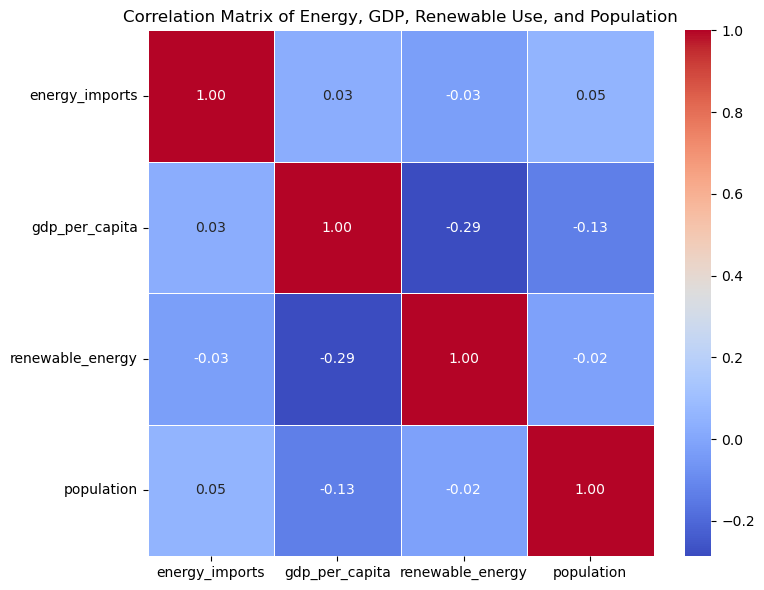

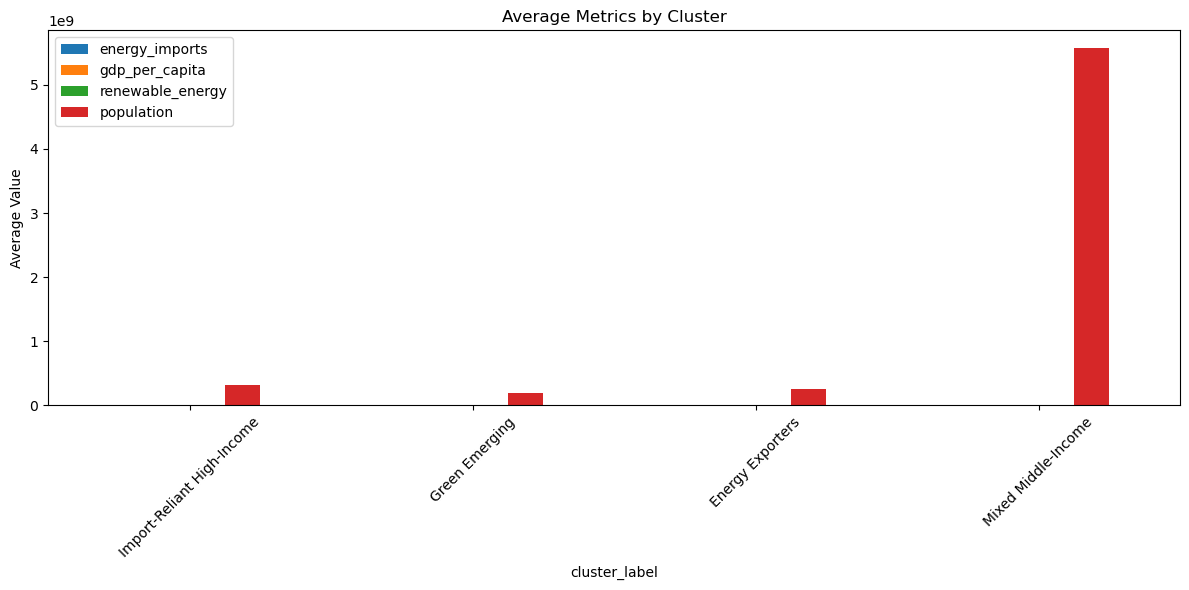

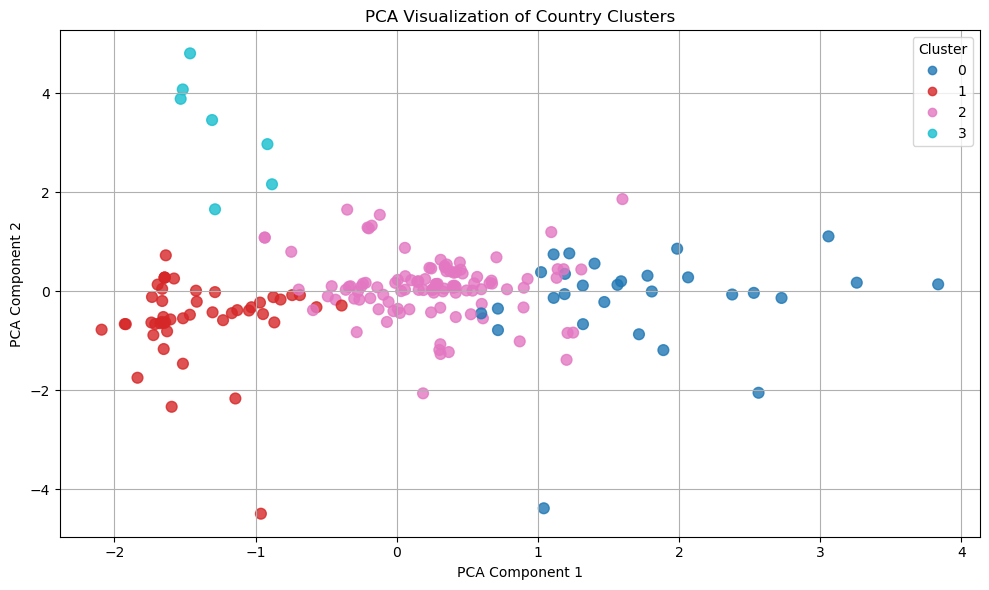

/var/folders/_b/lctq89td1nn8kzgybmc2b7hm0000gn/T/ipykernel_13356/3352752601.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='cluster_label', y='energy_imports', palette='tab10')


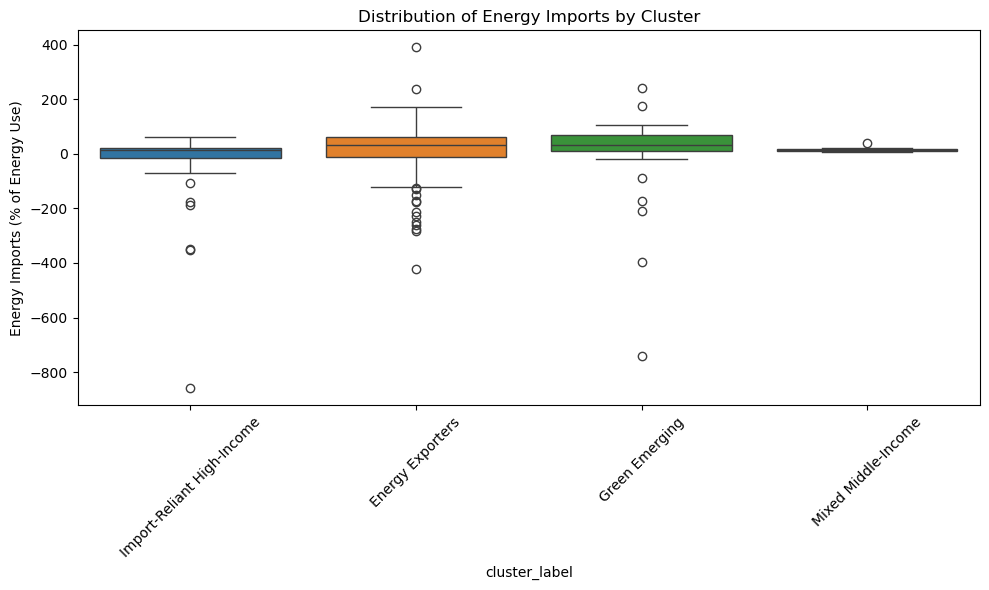

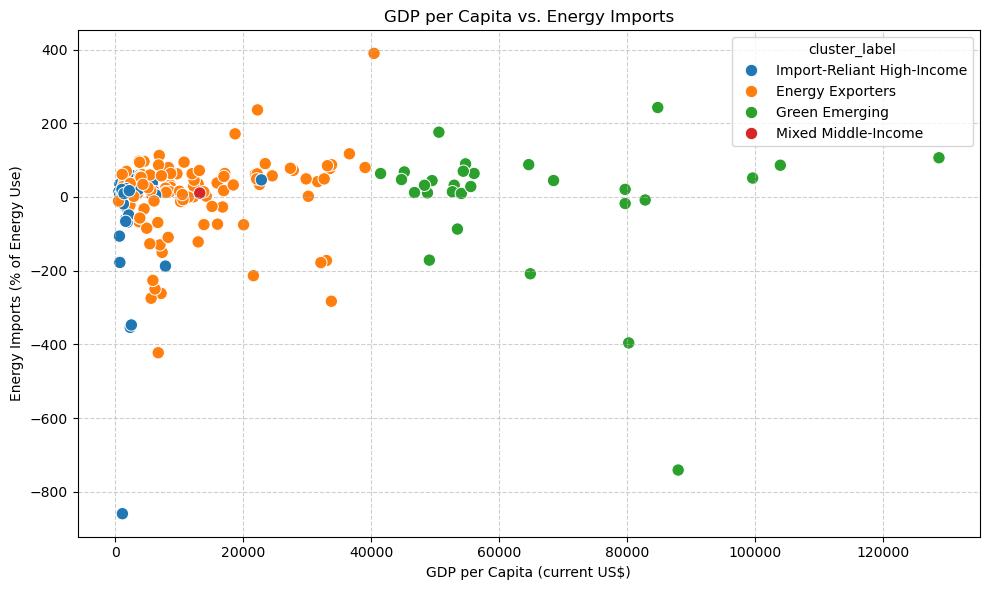

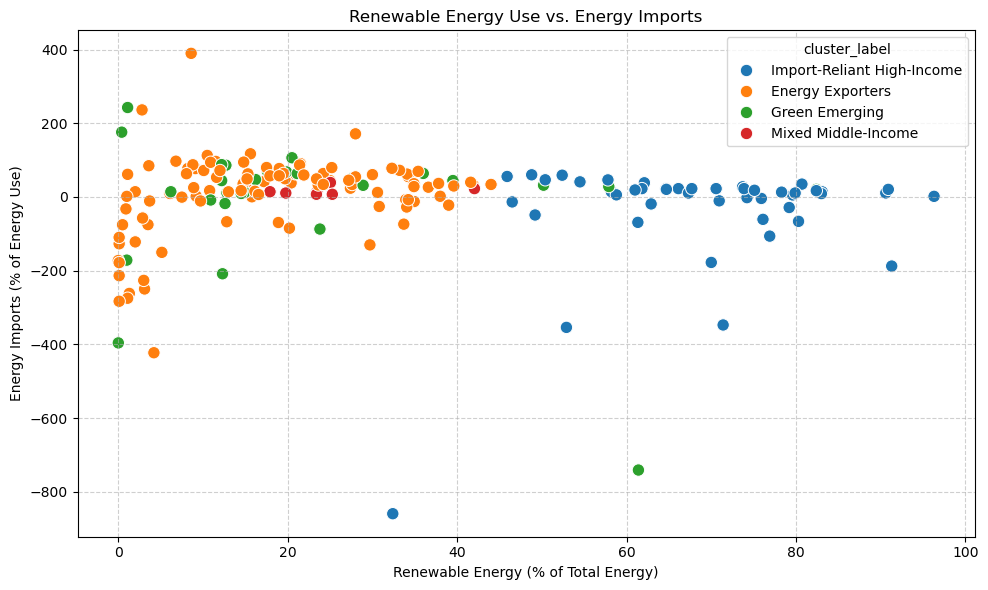

✅ Analysis complete. Charts and dataset exported.


In [3]:
# World Bank Data Bank: Energy Import Analysis
# Exploring the energy import dependency of countries using public World Bank data,
# along with GDP per capita, renewable energy use, and population statistics. We'll perform regression,
# clustering, and PCA for insight generation.

# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm

# Datasets
energy_df = pd.read_csv("API_21_DS2_en_csv_v2_23942.csv", skiprows=4) # energy importr
gdp_df = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_19346.csv", skiprows=4) # GDP per capita
renew_df = pd.read_csv("API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_21029.csv", skiprows=4)# reneable energy consumption
pop_df = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_19373.csv", skiprows=4) #population

# Extract Latest Valid Year
def extract_latest_value(df, indicator, value_name):
    subset = df[df['Indicator Name'] == indicator].copy()
    year_cols = subset.columns[4:-1]
    subset[value_name] = subset[year_cols].apply(lambda row: row.dropna().iloc[-1] if row.dropna().any() else None, axis=1)
    return subset[['Country Name', value_name]]

energy = extract_latest_value(energy_df, 'Energy imports, net (% of energy use)', 'energy_imports')
gdp = extract_latest_value(gdp_df, 'GDP per capita (current US$)', 'gdp_per_capita')
renewable = extract_latest_value(renew_df, 'Renewable energy consumption (% of total final energy consumption)', 'renewable_energy')
population = extract_latest_value(pop_df, 'Population, total', 'population')

# Merging All Metrics
merged_df = energy.merge(gdp, on='Country Name') \
                  .merge(renewable, on='Country Name') \
                  .merge(population, on='Country Name') \
                  .set_index('Country Name') \
                  .dropna()

# Run Regression Analysis
X = merged_df[['gdp_per_capita', 'renewable_energy', 'population']]
y = merged_df['energy_imports']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Clustering & PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

clustered_df = merged_df.copy()
clustered_df['cluster'] = clusters

cluster_labels = {
    0: "Green Emerging",
    1: "Import-Reliant High-Income",
    2: "Energy Exporters",
    3: "Mixed Middle-Income"
}

clustered_df['cluster_label'] = clustered_df['cluster'].map(cluster_labels)
clustered_df['Country'] = clustered_df.index

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

## Generating Viz ##



# Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Energy, GDP, Renewable Use, and Population")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# Clusters average
cluster_avg = clustered_df.groupby('cluster_label')[['energy_imports', 'gdp_per_capita', 'renewable_energy', 'population']].mean().sort_values(by='energy_imports')
cluster_avg.plot(kind='bar', figsize=(12, 6))
plt.title("Average Metrics by Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("cluster_averages.png")
plt.show()

# PCA Clustering plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='tab10', s=60, alpha=0.8)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Country Clusters")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.savefig("pca_clusters.png")
plt.show()

# Distribution of Energy Imports by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=clustered_df, x='cluster_label', y='energy_imports', palette='tab10')
plt.title("Distribution of Energy Imports by Cluster")
plt.ylabel("Energy Imports (% of Energy Use)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("energy_imports_distribution_by_cluster.png")
plt.show()

# Scatter Plot: GDP vs Energy Imports
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_df, x='gdp_per_capita', y='energy_imports', hue='cluster_label', palette='tab10', s=80)
plt.title("GDP per Capita vs. Energy Imports")
plt.xlabel("GDP per Capita (current US$)")
plt.ylabel("Energy Imports (% of Energy Use)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("gdp_vs_energy_imports.png")
plt.show()

# Scatter Plot: Renewable vs Energy Imports
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_df, x='renewable_energy', y='energy_imports', hue='cluster_label', palette='tab10', s=80)
plt.title("Renewable Energy Use vs. Energy Imports")
plt.xlabel("Renewable Energy (% of Total Energy)")
plt.ylabel("Energy Imports (% of Energy Use)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("renewables_vs_energy_imports.png")
plt.show()

# Exporting Final Dataset
clustered_df = clustered_df[['Country', 'energy_imports', 'gdp_per_capita', 'renewable_energy', 'population', 'cluster', 'cluster_label']]
clustered_df.to_csv("Clustered_Country_Profiles.csv", index=False)


# print("✅ Analysis complete. Charts and dataset exported.")
